In [1]:
import numpy as np
import math
import cmath

import ipywidgets
import matplotlib.pyplot as plt

import scipy.integrate as integrate
from numpy import pi
from copy import deepcopy

from scipy.stats import norm

In [2]:
# physics elements
m_u = 1.6605e-27
m_He = 4*m_u
k_B = 1.380649e-23
h_constant = 6.62607015e-34
T=298
k_magnitude = 2*pi*np.sqrt(5*m_He*k_B*T)/h_constant
Wavelength = 2*pi/k_magnitude*1e10 #wavelength of helium beam in A
eV = 1.60218e-19

In [3]:
def get_diffraction_angle(lattice_constant, lattice_vector_1, lattice_vector_2, miller_index_1, miller_index_2, lattice_orentation, incident_theta, incident_phi, beam_energy):
    '''
    lattice constant - lattice constant in angstrom, float
    lattice_vector - surface lattice vector, list
    miller_index - reciprocal space Miller indices, integer
    lattice_orentation - orientation of lattice vector in degree, deg, float/integer
    incident_theta/phi - incident beam theta and phi, deg, float/integer
    beam_energy - energy of the helium beam, meV

    theta_f, phi_f - diffracted beam theta and phi in real space, rad, float/integer
    phi_k - diffracted beam phi in K space, rad, float/integer
    '''

    # change global to local variable
    a = deepcopy(lattice_constant)
    a1 = deepcopy(lattice_vector_1) 
    a2 = deepcopy(lattice_vector_2)
    h = deepcopy(miller_index_1)
    k = deepcopy(miller_index_2)
    alpha_angle = deepcopy(lattice_orentation)
    theta_i = deepcopy(incident_theta)
    phi_i = deepcopy(incident_phi)
    beam_energy = deepcopy(beam_energy)

    alpha_angle = alpha_angle/180*pi # deg to rad
    theta_i = theta_i/180*pi
    phi_i = phi_i/180*pi

    a3 = [0, 0, 1] # only consider 2d surface
  
    # calculate reciprocal space lattice vector
    x1 = a1[0]
    y1 = a1[1]
    a1[0] = x1*np.cos(alpha_angle) - y1*np.sin(alpha_angle)
    a1[1] = x1*np.sin(alpha_angle) + y1*np.cos(alpha_angle)
    a1 = [ i * a for i in a1]

    x2 = a2[0]
    y2 = a2[1]
    a2[0] = x2*np.cos(alpha_angle) - y2*np.sin(alpha_angle)
    a2[1] = x2*np.sin(alpha_angle) + y2*np.cos(alpha_angle)
    a2 = [ i * a for i in a2]

    b1 = 2*pi*np.cross(a2,a3) / (np.dot(a1, np.cross(a2,a3))) # reciporcal lattice vector, list
    b2 = 2*pi*np.cross(a3,a1) / (np.dot(a1, np.cross(a2,a3)))

    set_energy = beam_energy * 1e-3 * 1.60218e-19  # meV to J
    wavelength = np.sqrt(1/(2*set_energy*m_He/h_constant**2))*1e10   # wavelength in A

    k_i = 2*pi/wavelength # incident wave vector, float
    K_i = [k_i*np.sin(theta_i)*np.cos(phi_i), k_i*np.sin(theta_i)*np.sin(phi_i)] # surface parallel component of incident beam, list 
    DK = h*np.array(b1[0:2]) + k*np.array(b2[0:2]) # change in K in every diffraction channel, array     
    K_f = K_i + DK # surface parallel component of diffracted beam, array 

    k_fz_square = k_i**2 - np.sum(np.array(K_f)**2)
    if k_fz_square < 0:
        k_fz_square = np.nan
    k_fz = np.sqrt(k_fz_square) # surface perpendicular component of diffracted beam, float

    theta_f = np.arccos(k_fz/k_i) # diffraction theta in real space, rad
    phi_f = myatan([K_f[1]], [K_f[0]]) # diffraction phi in real space, rad
    phi_k = myatan([DK[1]], [DK[0]]) # diffraction phi in K space, rad

    return(theta_f, phi_f, phi_k, K_i, k_i)

def get_detector_angle(z_position, pinhole_detector_seperation, In_plane_axis, Out_plane_axis, incident_theta, incident_phi, beam_energy, height_difference,aperture_tilt):
    '''
    z_position - z positions in mm, float
    pinhole_detector_seperation - vertical distance between center of pinhole plate and center of detector aperture in mm
    I_axis, O_axis - length of in-plane and out-plane full axis of the detctor aperture in mm
    theta_i, phi_i - incident beam theta and phi, deg, float/integer
    beam_energy - energy of the helium beam, meV
    height_difference - the difference in height of the pinhole and detector aperture conic structure, Height_pinhole-Height_detector, mm
    aperture_tilt - tileness of the detector aperture, deg

    theta_range - the range of acceptance theta of the detector aperture, rad
    azimuthal_range - the range of acceptance phi of the detector aperture, rad
    DK_phi - azimuthal angle of the parallel momentum transfer, rad
    '''

    # change global to local variable
    z = deepcopy(z_position)
    b = deepcopy(pinhole_detector_seperation)
    I_axis = deepcopy(In_plane_axis)
    O_axis = deepcopy(Out_plane_axis)
    theta_i = deepcopy(incident_theta)
    phi_i = deepcopy(incident_phi)
    beam_energy = deepcopy(beam_energy)
    height_difference = deepcopy(height_difference)
    aperture_tilt = deepcopy(aperture_tilt)
    
    theta_i = theta_i/180*pi # deg to rad
    phi_i = phi_i/180*pi
    aperture_tilt = aperture_tilt/180*pi

    Z = z + height_difference # to calculate detection angle

    B = b - z*np.tan(theta_i)

    in_plane_range = np.linspace(B - I_axis/2*np.cos(aperture_tilt), B + I_axis/2*np.cos(aperture_tilt), 200) #vertical distance between diffraction spot and detector aperture, in-plane, array
    in_plane_axis_range = np.linspace(-I_axis/2, I_axis/2, 200) # the range of in-plane axis, used for calculating length of out-plane acceptance length at any in-plane position, array
    out_plane_distance = np.sqrt(np.abs(((I_axis/2)**2 * (O_axis/2)**2 - (O_axis/2)**2 * in_plane_axis_range**2)/(I_axis/2)**2)) #using ellipse equation to calculate length of out-plane acceptance at any in-plane position,array, using abs because small negative number -3e-16 etc, maybe due to linspace before
    point_to_detector_range = np.sqrt(out_plane_distance**2+in_plane_range**2) # distance between diffraction spot and a point on the edge of detector aperture in the aperture parallel plane
    Zz = np.linspace(Z+I_axis/2*np.sin(aperture_tilt), Z-I_axis/2*np.sin(aperture_tilt), 200)
    theta_accept_range = myatan(point_to_detector_range,Zz) #range of in-plane detection angle
    theta_range = np.concatenate([theta_accept_range, np.flip(theta_accept_range)]) #flip for drawing plot

    out_plane_coord = np.concatenate([out_plane_distance,-np.flip(out_plane_distance)])
    azimuthal_range = myatan(out_plane_coord,np.concatenate([in_plane_range,np.flip(in_plane_range)])) #flip for drawing plot, array

    set_energy = beam_energy * 1e-3 * 1.60218e-19  # meV to J
    wavelength = np.sqrt(1/(2*set_energy*m_He/h_constant**2))*1e10   # wavelength in A

    k_i = 2*pi/wavelength
    K_i = [k_i*np.sin(theta_i)*np.cos(phi_i), k_i*np.sin(theta_i)*np.sin(phi_i)] # the surface parallel component of the incident wave vector, list
    K_fx = k_i*np.sin(theta_range)*np.cos(azimuthal_range) # surface parallel components of the outgoing wave vector
    K_fy = k_i*np.sin(theta_range)*np.sin(azimuthal_range)# surface parallel components of the outgoing wave vector
    DK_x = K_fx - K_i[0] 
    DK_y = K_fy - K_i[1] # parallel momentum transfer
    DK_phi = myatan(DK_y, DK_x) # azimuthal angle of the parallel momentum transfer
    return(theta_range, azimuthal_range, DK_phi)

def plot_figures_polar(x = 20, a=3.16, incident_angle_theta=30, incident_angle_phi=0, para_axis = 0.6, vert_axis = 0.9, z_position = 4.0, pinhole_sepe = 5.0, latt_orientation = 30, height_difference=0,aperture_tilt=0):

    maxh=x
    maxk=x
    a = a # lattice constant in A
    incident_angle_theta = incident_angle_theta
    incident_angle_phi = incident_angle_phi
    para_axis = para_axis # length of the in-plane axis of the detector aperture in mm
    vert_axis = vert_axis # length of the out-plane axis of the detector aperture in mm
    z_position = z_position # position of Z in mm
    pinhole_sepe = pinhole_sepe # seperation between pinhole and detector aperture in mm
    latt_vector_1 = [1, 0, 0]
    latt_vector_2 = [0.50, 3**.5/2, 0]
    #latt_vector_2 = [0, 1, 0]
    latt_orientation = latt_orientation

    H = []
    K = []
    Theta = [] # diffraction polar angle
    Phi = [] #diffraction azimuthal angle in real space
    Phi_k = [] # diffraction azimuthal angle in K space

    fig = plt.figure(figsize=(14,14))
    ax = fig.add_subplot(111, projection='polar')

    for i in range(-maxk, maxk+1):
        for j in range(-maxh, maxh+1):
            theta_f, phi_f, phi_k, _, _ = get_diffraction_angle(a, latt_vector_1, latt_vector_2, i, j, latt_orientation, incident_angle_theta, incident_angle_phi)
            if np.isnan(theta_f) == False:
                H.append(i)
                K.append(j)
                Theta.append(theta_f)
                Phi.append(phi_f)
                Phi_k.append(phi_k)

                dK = np.sqrt((k_magnitude*np.sin(theta_f)*np.cos(phi_f)-k_magnitude*np.sin(incident_angle_theta/180*pi))**2+(k_magnitude*np.sin(theta_f)*np.sin(phi_f))**2)/1e10

                ax.plot(phi_k,dK,'r.',)
                ax.annotate("{},{}".format(i,j), xy=[phi_k, dK])


    Theta = np.array(Theta).flatten()
    Phi = np.array(Phi).flatten()
    Phi_k = np.array(Phi_k).flatten()

    DK = np.sqrt((k_magnitude*np.sin(Theta)*np.cos(Phi)-k_magnitude*np.sin(incident_angle_theta/180*pi))**2+(k_magnitude*np.sin(Theta)*np.sin(Phi))**2)/1e10

    [detection_angle, azimuthal_angle, DK_phi]=get_detector_angle(z_position, pinhole_sepe, para_axis, vert_axis, incident_angle_theta, incident_angle_phi, height_difference,aperture_tilt)

    DK_detector = np.sqrt((k_magnitude*np.sin(detection_angle)*np.cos(azimuthal_angle)-k_magnitude*np.sin(incident_angle_theta/180*pi))**2+(k_magnitude*np.sin(detection_angle)*np.sin(azimuthal_angle))**2)/1e10
    
    #plt.figure(figsize=(14,14))
    #plt.polar(Phi_k,DK,'.')
    #ax.plot(DK_phi, DK_detector)
    ax.set_yticklabels([])
    add_scale(ax, label='DK',x_offset = 0)

def plot_figures_cart(
        x = 10, a=3.16, a11 = 1, a12 = 0, a21 = 0.5, a22 = 3**.5/2, beam_energy=64.2,
        para_axis = 0.6, vert_axis = 0.9,  pinhole_sepe = 5.0, z_position = 4.0, height_difference=0,aperture_tilt=0,
        incident_angle_theta=45, incident_angle_phi=0,latt_orientation = 0, reverse_latt_orientation_for_simulation=True,
        Mesh_size=1000, Kx_lim=[-25,5],Ky_lim=[-15,15],peak_width=0.3,
        use_reduce_in_signal_along_z = False, pattern_width = 10,
        use_bg_diffuse_signal = False, diffuse_width = 1, diffuse_scale = 0.4,
        use_multiscat = True, Multiscat_file_name = './MoS2_1x1.mtl', multiscat_angle_step=1,angle_compensate = 30,
        line_plot = True,  plot_detector_path=True, z_range=[0,8],z_range_space=50, return_line_result = False,
        save_plots = False, save_plots_index='hello world'
        ):

###### some initial inputs
    maxh=deepcopy(x)
    maxk=deepcopy(x)
    a = deepcopy(a) # lattice constant in A
    incident_angle_theta = deepcopy(incident_angle_theta)
    incident_angle_phi = deepcopy(incident_angle_phi)
    para_axis = deepcopy(para_axis) # length of the in-plane axis of the detector aperture in mm
    vert_axis = deepcopy(vert_axis) # length of the out-plane axis of the detector aperture in mm
    z_position = deepcopy(z_position) # position of Z in mm
    height_difference = deepcopy(height_difference) # difference in height of pinhole detector aperture conic structure, Height_detector - Height_pinhole, mm
    aperture_tilt = deepcopy(aperture_tilt) # the tiltness of the detetecor aperture, deg
    pinhole_sepe = deepcopy(pinhole_sepe) # seperation between pinhole and detector aperture in mm
    latt_vector_1 = [a11, a12, 0]
    latt_vector_2 = [a21, a22, 0]
    #latt_vector_2 = [0, 1, 0]
    latt_orientation = deepcopy(latt_orientation)
    latt_orientation = round(latt_orientation,1)  # floating sider
    angle_compensate = deepcopy(angle_compensate) # compensate difference between simulated and multiscat angle
    angle_compensate = round(angle_compensate,1)  # floating sider
    z_range = deepcopy(z_range)
    z_range_space = deepcopy(z_range_space)
    Mesh_size = deepcopy(Mesh_size)
    peak_width = deepcopy(peak_width)
    pattern_width = deepcopy(pattern_width)
    diffuse_width = deepcopy(diffuse_width)
    diffuse_scale = deepcopy(diffuse_scale)
    multiscat_angle_step = deepcopy(multiscat_angle_step)
    multiscat_angle_step = round(multiscat_angle_step,1)
    Kx_lim = deepcopy(Kx_lim)
    Ky_lim = deepcopy(Ky_lim)
    beam_energy = deepcopy(beam_energy)

    if reverse_latt_orientation_for_simulation == True:
        print('Lattice orientation in simulation:', -latt_orientation)
    else: 
        print('Lattice orientation in simulation:', latt_orientation)

    H = []
    K = []
    Theta = [] # diffraction polar angle
    Phi = [] #diffraction azimuthal angle in real space
    Phi_k = [] # diffraction azimuthal angle in K space

    Kxs = []
    Kys = []

    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)

    Number_of_peaks = 0
    Number_of_multiscat_peaks = 0

###################          import multiscat data
    if use_multiscat == True:
        Multiscat_Intensity = []                                             

        Multiscat_file_name = deepcopy(Multiscat_file_name)                  # multiscat file name

        start_angle = format_number(latt_orientation+angle_compensate)       # get the section needed
        end_angle = format_number(latt_orientation+multiscat_angle_step+angle_compensate)
        print('The lattice orientation imported from multiscat:',start_angle)

        with open(Multiscat_file_name, 'r') as Multiscat_data:
            text_lines = Multiscat_data.read().splitlines()
                        
        for text_index, text_content in enumerate(text_lines):

            if f'newmtl diffractive_{start_angle}deg' in text_content:
                start_index = text_index
            elif f'newmtl diffractive_{end_angle}deg' in text_content:
                end_index = text_index
        
        try:
            string_lines = text_lines[start_index+6:end_index]
        except:
            print('No multiscat data matched')
            return

        list_lines = []

        for k in range(len(string_lines)):                            # list of multiscat data [diff channel 1,  diff channel 2, intensity]
            list = string_lines[k].split()
            list = [float(element) for element in list]
            list_lines.append(list)
###################      calculate non imaginary dk, get therotical diffraction peak positions

###
    if reverse_latt_orientation_for_simulation == True:
        latt_orientation = -latt_orientation
###
    
    for i in range(-maxk, maxk+1):
        for j in range(-maxh, maxh+1):
            theta_f, phi_f, phi_k, K_i, k_i = get_diffraction_angle(a, latt_vector_1, latt_vector_2, i, j, latt_orientation, incident_angle_theta, incident_angle_phi, beam_energy)    # calculate each diffraction position
            if np.isnan(theta_f) == False:
                H.append(i)
                K.append(j)
                Theta.append(theta_f)
                Phi.append(phi_f)
                Phi_k.append(phi_k)

                dK = np.sqrt((k_magnitude*np.sin(theta_f)*np.cos(phi_f)-k_magnitude*np.sin(incident_angle_theta/180*pi))**2+(k_magnitude*np.sin(theta_f)*np.sin(phi_f))**2)/1e10

                Kx = dK * np.cos(phi_k)
                Ky = dK * np.sin(phi_k) # polar to cartesian

                Kxs.append(Kx)
                Kys.append(Ky)

                Number_of_peaks = Number_of_peaks + 1             # number of simulated peaks

                ax.plot(Kx,Ky,'r.',)                              # plot peak positions 
                ax.annotate("{},{}".format(i,j), xy=[Kx, Ky])   

######      assign multiscat diffraction intensities to designated peak positions
                if use_multiscat == True:
                    Multiscat_Intensity.append(0)                 # intensity = 0 if not match

                    
                    
                    for k in range(len(string_lines)):
                        if list_lines[k][0] == i and list_lines[k][1] == j: 
                            Multiscat_Intensity[len(Multiscat_Intensity)-1] = np.log10(list_lines[k][2]*1e8)    # replace 0 with multiscat intensity if diffraction channel matches
                                                                                                                # log10 used to redeuce difference between intensities and make plot better
                            Number_of_multiscat_peaks = Number_of_multiscat_peaks + 1
 
    if use_multiscat == True:                          
        Multiscat_Intensity = np.array(Multiscat_Intensity)
        Multiscat_Intensity = Multiscat_Intensity/max(Multiscat_Intensity)
        #Number_of_multiscat_peaks =np.count_nonzero(Multiscat_Intensity)
        print('Number of Multiscat peaks:',Number_of_multiscat_peaks)       # number of diffraction peaks that having matched multiscat data

#######     create normal distribution based peak shape to each peak position           
    print('Number of Therotical Peaks:',Number_of_peaks)

    Theta = np.array(Theta).flatten()
    Phi = np.array(Phi).flatten()
    Phi_k = np.array(Phi_k).flatten()
    Kxs = np.array(Kxs).flatten()
    Kys = np.array(Kys).flatten()

    Kzs = np.sqrt(Kxs**2 + Kys**2)

    Kx_max = max(Kxs)
    Kx_min = min(Kxs)
    Ky_max = max(Kys)
    Ky_min = min(Kys)

    Mesh_size = Mesh_size

    #Kxs_linsp = np.linspace(Kx_min-1,Kx_max+1,Mesh_size)
    #Kys_linsp = np.linspace(Ky_min-1,Ky_max+1,Mesh_size)

    Kxs_linsp = np.linspace(Kx_lim[0],Kx_lim[1],Mesh_size)
    Kys_linsp = np.linspace(Ky_lim[0],Ky_lim[1],Mesh_size)


    Kx_mesh, Ky_mesh = np.meshgrid(Kxs_linsp,Kys_linsp)              # mesh grid                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             
    Intensity_Mesh = Kx_mesh*0 + Ky_mesh*0                              

    for i in range(len(Kxs)):

        peak_width = peak_width                                            # diffraction peak width
        pattern_width = pattern_width                                      # diffraction pattern
        diffuse_width = diffuse_width                                      # diffuse width

     #   if use_multiscat == True:
     #       Diffraction_peak_x = norm.pdf(Kxs_linsp,Kxs[i],peak_width) * Multiscat_Intensity[i]  # generate diffraction peak using normal distrubution and apply multiscat intensities
     #       Diffraction_peak_y = norm.pdf(Kys_linsp,Kys[i],peak_width) * Multiscat_Intensity[i]
     #   else:
     #       Diffraction_peak_x = norm.pdf(Kxs_linsp,Kxs[i],peak_width)  # generate diffraction peak using normal distrubution
     #       Diffraction_peak_y = norm.pdf(Kys_linsp,Kys[i],peak_width)

        if use_multiscat == True:
            Diffraction_peak_x = norm.pdf(Kxs_linsp,Kxs[i],peak_width) * Multiscat_Intensity[i]  # generate diffraction peak using normal distrubution and apply multiscat intensities
            Diffraction_peak_y = norm.pdf(Kys_linsp,Kys[i],peak_width) * Multiscat_Intensity[i]
        else:
            Diffraction_peak_x = norm.pdf(Kxs_linsp,Kxs[i],peak_width)  # generate diffraction peak using normal distrubution
            Diffraction_peak_y = norm.pdf(Kys_linsp,Kys[i],peak_width)


        if use_reduce_in_signal_along_z == True:
            Reduce_in_signal = norm.pdf(Kzs[i], 0, pattern_width)        # simulate reduce in signal intensity along z
            Intensity_Mesh = Intensity_Mesh + Reduce_in_signal*(np.array([Diffraction_peak_y]).T*Diffraction_peak_x) # the mesh of diffraction peaks     
        else:   
            Intensity_Mesh = Intensity_Mesh + (np.array([Diffraction_peak_y]).T*Diffraction_peak_x) # the mesh of diffraction peaks
        
    Intensity_Mesh = (Intensity_Mesh/np.amax(Intensity_Mesh)) 
    #Intensity_Mesh = Intensity_Mesh
    ###debug plot
    #plt.plot(Kxs_linsp,Diffraction_peak_x)


    if use_bg_diffuse_signal == True:
        Diffuse_x = norm.pdf(Kxs_linsp, 0, diffuse_width)
        Diffuse_y = norm.pdf(Kys_linsp, 0, diffuse_width)
        Diffuse_Mesh = (np.array([Diffuse_y]).T*Diffuse_x)
        Diffuse_Mesh = (Diffuse_Mesh/np.amax(Diffuse_Mesh))
    
        Intensity_Mesh = Intensity_Mesh + Diffuse_Mesh*diffuse_scale
                    

    img = ax.pcolormesh(Kx_mesh,Ky_mesh, Intensity_Mesh)

    DK = np.sqrt((k_magnitude*np.sin(Theta)*np.cos(Phi)-k_magnitude*np.sin(incident_angle_theta/180*pi))**2+(k_magnitude*np.sin(Theta)*np.sin(Phi))**2)/1e10

    [detection_angle, azimuthal_angle, DK_phi]=get_detector_angle(z_position, pinhole_sepe, para_axis, vert_axis, incident_angle_theta, incident_angle_phi, beam_energy, height_difference,aperture_tilt) # detector position in the plot

    DK_detector = np.sqrt((k_magnitude*np.sin(detection_angle)*np.cos(azimuthal_angle)-k_magnitude*np.sin(incident_angle_theta/180*pi))**2+(k_magnitude*np.sin(detection_angle)*np.sin(azimuthal_angle))**2)/1e10
      
    Detector_Kx = DK_detector * np.cos(DK_phi)
    Detector_Ky = DK_detector * np.sin(DK_phi)
    
    fig.colorbar(img)
    diffraction_circle = plt.Circle((-K_i[0],K_i[1]), k_i, color='orange',fill=False)
    ax.add_patch(diffraction_circle)
    ax.plot(Detector_Kx,Detector_Ky,color='white')
    ax.axis('equal')

##### debug plot
   # _, _, Inside_Detector_Intensity_Mesh= find_signal_inside_detector(Kx_mesh, Ky_mesh, Intensity_Mesh, z_position, pinhole_sepe, para_axis, vert_axis, incident_angle_theta, incident_angle_phi)

    #ax.pcolormesh(Kx_mesh,Ky_mesh,Inside_Detector_Intensity_Mesh,cmap='gray')
    #ax.axis('equal')
#####


   
   

    ##### line plot that simulates the line scan in real SHeM
    if line_plot == True:                            # line plot generation
        z_positions = np.linspace(z_range[0],z_range[1],z_range_space)
        Inside_Detector_Intensities = []
        DK_xs_line_plot = []
        for j in range(len(z_positions)):
            Inside_Detector_Intensity, DK_x_line_plot, _= find_signal_inside_detector(Kx_mesh, Ky_mesh, Intensity_Mesh, z_positions[j], pinhole_sepe, 
                                                                                      para_axis, vert_axis, incident_angle_theta, incident_angle_phi,beam_energy, height_difference,aperture_tilt)
            Inside_Detector_Intensities.append(Inside_Detector_Intensity)
            DK_xs_line_plot.append(DK_x_line_plot)
        plt.figure()
        plt.plot(np.array(DK_xs_line_plot)*10, np.array(Inside_Detector_Intensities),'-')
        plt.xlabel('Dkx/nm^-1')
        plt.ylabel('Sum of log10(I*1e8) inside detector')

        if save_plots == True:
            if use_multiscat ==True:
                saved_fig_name = 'Line_scans_' + str(start_angle) + '_'+save_plots_index+'.png'
            else:
                saved_fig_name = 'Line_scans_' + str(latt_orientation) + '_'+save_plots_index+'.png'
            plt.savefig(saved_fig_name)
        if return_line_result == True:
            return(latt_orientation, np.array(DK_xs_line_plot), np.array(Inside_Detector_Intensities))
    
    if plot_detector_path == True:
        z_positions = np.linspace(z_range[0],z_range[1],z_range_space)

        Detector_Ky_max = []
        Detector_Ky_min = []
        Detector_Kx_mid = []

        for j in range(len(z_positions)):

            [detection_angle, azimuthal_angle, DK_phi]=get_detector_angle(z_positions[j], pinhole_sepe, para_axis, vert_axis, incident_angle_theta, incident_angle_phi, beam_energy, height_difference,aperture_tilt)

            DK_detector = np.sqrt((k_magnitude*np.sin(detection_angle)*np.cos(azimuthal_angle)-k_magnitude*np.sin(incident_angle_theta/180*pi))**2+(k_magnitude*np.sin(detection_angle)*np.sin(azimuthal_angle))**2)/1e10
            
            Detector_Ky = DK_detector * np.sin(DK_phi)
            Detector_Kx = DK_detector * np.cos(DK_phi)

            Detector_Ky_max.append(max(Detector_Ky))
            Detector_Ky_min.append(min(Detector_Ky))
            Detector_Kx_mid.append((max(Detector_Kx)+min(Detector_Kx))/2)

            if j == 0:

                idx = np.where(Detector_Kx > ((max(Detector_Kx)+min(Detector_Kx))/2))
                ax.plot(Detector_Kx[idx], Detector_Ky[idx],color='white')

            if j == range(len(z_positions))[-1]:

                idx = np.where(Detector_Kx < ((max(Detector_Kx)+min(Detector_Kx))/2))
                Detector_Kx_sliced = Detector_Kx[idx]
                Detector_Ky_sliced = Detector_Ky[idx]
                Detector_Kx_sliced[:round(len(Detector_Ky_sliced)/2)] = Detector_Kx_sliced[:round(len(Detector_Ky_sliced)/2)][::-1]
                Detector_Kx_sliced[round(len(Detector_Ky_sliced)/2):] = Detector_Kx_sliced[round(len(Detector_Ky_sliced)/2):][::-1]
                Detector_Ky_sliced[:round(len(Detector_Ky_sliced)/2)] = Detector_Ky_sliced[:round(len(Detector_Ky_sliced)/2)][::-1]
                Detector_Ky_sliced[round(len(Detector_Ky_sliced)/2):] = Detector_Ky_sliced[round(len(Detector_Ky_sliced)/2):][::-1]

                ax.plot(Detector_Kx_sliced, Detector_Ky_sliced,color='white')

        ax.plot(Detector_Kx_mid,Detector_Ky_max,color='white')
        ax.plot(Detector_Kx_mid,Detector_Ky_min,color='white')
        ax.axis('equal')

    #### 2D polar plot
    if save_plots == True:
        saved_fig_name = 'Diffraction_peaks_' + save_plots_index
        fig.savefig(saved_fig_name)


# sum of mesh grid intensity inside detector range
def find_signal_inside_detector(Mesh_X, Mesh_Y, Mesh_Intensity, z_position, pinhole_sepe, para_axis, vert_axis, incident_angle_theta, incident_angle_phi,beam_energy, height_difference,aperture_tilt): 

    [detection_angle, azimuthal_angle, DK_phi]=get_detector_angle(z_position, pinhole_sepe, para_axis, vert_axis, incident_angle_theta, incident_angle_phi,beam_energy, height_difference,aperture_tilt)

    DK_detector = np.sqrt((k_magnitude*np.sin(detection_angle)*np.cos(azimuthal_angle)-k_magnitude*np.sin(incident_angle_theta/180*pi))**2+(k_magnitude*np.sin(detection_angle)*np.sin(azimuthal_angle))**2)/1e10

    Detector_Kx = DK_detector * np.cos(DK_phi)
    Detector_Ky = DK_detector * np.sin(DK_phi)

    Detector_Kx_center = (max(Detector_Kx) + min(Detector_Kx))/2
    Detector_Ky_center = (max(Detector_Ky) + min(Detector_Ky))/2
    para_axis_dk = abs(max(Detector_Kx) - min(Detector_Kx))/2
    vert_axis_dk = abs(max(Detector_Ky) - min(Detector_Ky))/2

    filter = (Mesh_X - Detector_Kx_center)**2/(para_axis_dk)**2 + (Mesh_Y - Detector_Ky_center)**2/(vert_axis_dk)**2    # ellipse equation
    Inside_Detector_idx = np.argwhere(filter<1)         # inside if < 1, get index

    #idx_x = np.argwhere(Mesh_X <max(Detector_Kx))
    #idx_x = np.argwhere(Mesh_X[idx_x] >min(Detector_Kx))
    #print(idx_x)
    #for i in range(len(Detector_Kx)/2):

        #idx_y = np.argwhere



    Inside_Detector_Intensity_list = []
    Inside_Detector_Intensity_Mesh = np.zeros(Mesh_X.shape) # mesh grid with 0 intensity

    for i in range(len(Inside_Detector_idx)):

        Inside_Detector_Intensity_list.append(Mesh_Intensity[tuple(Inside_Detector_idx[i])])   # get intensities that are in the detector
        Inside_Detector_Intensity_Mesh[tuple(Inside_Detector_idx[i])] = Mesh_Intensity[tuple(Inside_Detector_idx[i])]
        
    Inside_Detector_Intensity = np.sum(Inside_Detector_Intensity_list)

    return(Inside_Detector_Intensity, Detector_Kx_center,Inside_Detector_Intensity_Mesh)

# supporting functions
def myatan(y,x):
    v=[]
    for i in range(len(y)):
        xi = x[i]
        yi = y[i]
        if xi>0:
            vi=np.arctan(yi/xi)

        if yi>=0 and xi<0:
            vi=pi+np.arctan(yi/xi)

        if yi<0 and xi<0:
            vi=-pi+np.arctan(yi/xi)

        if yi>0 and xi==0:
            vi=pi/2

        if yi<0 and xi==0:
            vi=-pi/2

        if yi == 0 and xi ==0:
            vi=0
       # print(yi,xi, vi)
        if vi<0:
            vi=vi+2*pi

        v.append(vi)
    return(np.array(v))

def add_scale(ax, label, x_offset=0):
    '''A function to add an extra x scale to the polar plot with the provided
    axis handle. The offset determines where the scale is drawn.
    
    Inputs:
        ax - axis handle on which to add an extra scale
        label - text label for the new scale
        x_offset - how far to the left of the plot to add the new scale
    '''
    
    # add extra axes for the scale
    rect = ax.get_position()
    rect = (rect.xmin-x_offset, rect.ymin+rect.height/2, # x, y
            rect.width, rect.height/2) # width, height
    scale_ax = ax.figure.add_axes(rect)
    # hide most elements of the new axes
    for loc in ['right', 'top', 'bottom']:
        scale_ax.spines[loc].set_visible(False)
    scale_ax.tick_params(bottom=False, labelbottom=False)
    scale_ax.patch.set_visible(False) # hide white background
    # adjust the scale
    scale_ax.spines['left'].set_bounds(*ax.get_ylim())
    scale_ax.set_yticks(ax.get_yticks())
    scale_ax.set_ylim(ax.get_rorigin(), ax.get_rmax())
    scale_ax.set_ylabel(label)
    return(scale_ax)

def format_number(n):
    if n == int(n):
        return int(n)
    else:
        return n

In [4]:
style = {'description_width': 'initial'}
ipywidgets.interact(plot_figures_cart, 
                    x = ipywidgets.IntText(value=10,description='Diffraction channel:',disabled=False, style=style),
                    a = ipywidgets.FloatText(value=3.16,description='Lattice constant(A):',disabled=False, style=style),
                    a11 = ipywidgets.FloatText(value=1,description='Lattice vector 1 1:',disabled=False, style=style),
                    a12 = ipywidgets.FloatText(value=0,description='Lattice vector 1 2:',disabled=False, style=style),
                    a21 = ipywidgets.FloatText(value=-0.5,description='Lattice vector 2 1',disabled=False, style=style),
                    a22 = ipywidgets.FloatText(value=3**.5/2,description='Lattice vector 2 2',disabled=False, style=style),
                    para_axis = ipywidgets.BoundedFloatText(value=0.5,step=0.1,description='In-plane axis(mm)',disabled=False, style=style),
                    vert_axis = ipywidgets.BoundedFloatText(value=0.5,step=0.1,description='Out-plane axis(mm)',disabled=False, style=style),
                    pinhole_sepe = ipywidgets.BoundedFloatText(value=5.0,step=0.1,description='Pinhole-Detector Seperation(mm)',disabled=False, style=style),
                    z_position=ipywidgets.FloatSlider(value=2.50,min=0, max=12,step=0.05,readout=True,readout_format='.2f',description='Sample z position(mm)', style=style),
                    incident_angle_theta=ipywidgets.FloatSlider(value=45,min=0, max=90,step=1,readout=True,readout_format='.1f', description='Incident angle theta',style=style),
                    incident_angle_phi=ipywidgets.FloatSlider(value=0,min=0, max=90,step=2,readout=True,readout_format='.1f',description='Incident angle phi(broken)', style=style),
                    latt_orientation=ipywidgets.FloatSlider(value=30, min=-180.0, max=180.0,step=0.5,readout=True,readout_format='.1f',description='Lattice orientation',style=style),
                    z_range=ipywidgets.FloatRangeSlider(value=[2, 6],min=0,max=12.0,step=0.1,description='z range(mm)',disabled=False,continuous_update=False,orientation='horizontal',readout=True,readout_format='.1f'),
                    angle_compensate = ipywidgets.FloatText(value=0,description='Angle compensation',disabled=False, style=style),
                    z_range_space = ipywidgets.IntText(value=50,description='z range linspace',disabled=False, style=style),
                    peak_width = ipywidgets.FloatSlider(value=0.3,step=0.05,description='Peak width',disabled=False, style=style),
                    pattern_width = ipywidgets.FloatSlider(value=10,step=0.1,description='Pattern width',disabled=False, style=style),
                    diffuse_width = ipywidgets.FloatSlider(value=10,step=0.1,description='Diffuse BG width',disabled=False, style=style),
                    diffuse_scale = ipywidgets.FloatSlider(value=0.4,step=0.1,min=0, max=1,description='Diffuse BG scale',disabled=False, style=style),
                    Mesh_size = ipywidgets.IntText(value=1000,description='Meshgrid resolution',disabled=False, style=style),
                    multiscat_angle_step= ipywidgets.FloatText(value=1,description='Angle step in Multiscat',disabled=False, style=style),
                    Kx_lim=ipywidgets.FloatRangeSlider(value=[-25, 5],min=-30,max=30.0,step=1.0,description='Kx mesh range',disabled=False,continuous_update=False,orientation='horizontal',readout=True,readout_format='.1f'),
                    Ky_lim=ipywidgets.FloatRangeSlider(value=[-15, 15],min=-30,max=30.0,step=1.0,description='Ky mesh range',disabled=False,continuous_update=False,orientation='horizontal',readout=True,readout_format='.1f'),
                    beam_energy = ipywidgets.FloatText(value=64.2,description='Beam Energy (meV)',disabled=False, style=style),
                    height_difference = ipywidgets.FloatSlider(value=0,step=0.1,min=-5,max=5,description='Height Difference(mm):',disabled=False, style=style),
                    aperture_tilt = ipywidgets.FloatSlider(value=0,step=5,min=0,max=90,description='Detector tiltness(deg):',disabled=False, style=style)
                    )

# mos2_1x1 a=3.16A (1 0)(-0.5 sqrt(3)/2) step=1 compensate=0 reverse=True
#MoS2_1x1_interp.mtl same as above

interactive(children=(IntText(value=10, description='Diffraction channel:', style=DescriptionStyle(description…

<function __main__.plot_figures_cart(x=10, a=3.16, a11=1, a12=0, a21=0.5, a22=0.8660254037844386, beam_energy=64.2, para_axis=0.6, vert_axis=0.9, pinhole_sepe=5.0, z_position=4.0, height_difference=0, aperture_tilt=0, incident_angle_theta=45, incident_angle_phi=0, latt_orientation=0, reverse_latt_orientation_for_simulation=True, Mesh_size=1000, Kx_lim=[-25, 5], Ky_lim=[-15, 15], peak_width=0.3, use_reduce_in_signal_along_z=False, pattern_width=10, use_bg_diffuse_signal=False, diffuse_width=1, diffuse_scale=0.4, use_multiscat=True, Multiscat_file_name='./MoS2_1x1.mtl', multiscat_angle_step=1, angle_compensate=30, line_plot=True, plot_detector_path=True, z_range=[0, 8], z_range_space=50, return_line_result=False, save_plots=False, save_plots_index='hello world')>

In [5]:
def plot_figures_cart_no_plot(
        x = 10, a=3.16, a11 = 1, a12 = 0, a21 = 0.5, a22 = 3**.5/2, beam_energy=64.2,
        para_axis = 0.6, vert_axis = 0.9,  pinhole_sepe = 5.0, z_position = 4.0, height_difference=0,aperture_tilt=0,
        incident_angle_theta=45, incident_angle_phi=0,latt_orientation = 0, reverse_latt_orientation_for_simulation=True,
        Mesh_size=1000, Kx_lim=[-25,5],Ky_lim=[-15,15],peak_width=0.3,
        use_reduce_in_signal_along_z = False, pattern_width = 10,
        use_bg_diffuse_signal = False, diffuse_width = 1, diffuse_scale = 0.4,
        use_multiscat = True, Multiscat_file_name = './MoS2_1x1.mtl', multiscat_angle_step=1,angle_compensate = 30,
        line_plot = True,  plot_detector_path=True, z_range=[0,8],z_range_space=50, return_line_result = False,
        save_plots = False, save_plots_index='hello world'
        ):

###### some initial inputs
    maxh=deepcopy(x)
    maxk=deepcopy(x)
    a = deepcopy(a) # lattice constant in A
    incident_angle_theta = deepcopy(incident_angle_theta)
    incident_angle_phi = deepcopy(incident_angle_phi)
    para_axis = deepcopy(para_axis) # length of the in-plane axis of the detector aperture in mm
    vert_axis = deepcopy(vert_axis) # length of the out-plane axis of the detector aperture in mm
    z_position = deepcopy(z_position) # position of Z in mm
    height_difference = deepcopy(height_difference) # difference in height of pinhole detector aperture conic structure, Height_detector - Height_pinhole, mm
    aperture_tilt = deepcopy(aperture_tilt) # the tiltness of the detetecor aperture, deg
    pinhole_sepe = deepcopy(pinhole_sepe) # seperation between pinhole and detector aperture in mm
    latt_vector_1 = [a11, a12, 0]
    latt_vector_2 = [a21, a22, 0]
    #latt_vector_2 = [0, 1, 0]
    latt_orientation = deepcopy(latt_orientation)
    latt_orientation = round(latt_orientation,1)  # floating sider
    angle_compensate = deepcopy(angle_compensate) # compensate difference between simulated and multiscat angle
    angle_compensate = round(angle_compensate,1)  # floating sider
    z_range = deepcopy(z_range)
    z_range_space = deepcopy(z_range_space)
    Mesh_size = deepcopy(Mesh_size)
    peak_width = deepcopy(peak_width)
    pattern_width = deepcopy(pattern_width)
    diffuse_width = deepcopy(diffuse_width)
    diffuse_scale = deepcopy(diffuse_scale)
    multiscat_angle_step = deepcopy(multiscat_angle_step)
    multiscat_angle_step = round(multiscat_angle_step,1)
    Kx_lim = deepcopy(Kx_lim)
    Ky_lim = deepcopy(Ky_lim)
    beam_energy = deepcopy(beam_energy)

    if reverse_latt_orientation_for_simulation == True:
        print('Lattice orientation in simulation:', -latt_orientation)
    else: 
        print('Lattice orientation in simulation:', latt_orientation)

    H = []
    K = []
    Theta = [] # diffraction polar angle
    Phi = [] #diffraction azimuthal angle in real space
    Phi_k = [] # diffraction azimuthal angle in K space

    Kxs = []
    Kys = []


    Number_of_peaks = 0
    Number_of_multiscat_peaks = 0

###################          import multiscat data
    if use_multiscat == True:
        Multiscat_Intensity = []                                             

        Multiscat_file_name = deepcopy(Multiscat_file_name)                  # multiscat file name

        start_angle = format_number(latt_orientation+angle_compensate)       # get the section needed
        end_angle = format_number(latt_orientation+multiscat_angle_step+angle_compensate)
        print('The lattice orientation imported from multiscat:',start_angle)

        with open(Multiscat_file_name, 'r') as Multiscat_data:
            text_lines = Multiscat_data.read().splitlines()
                        
        for text_index, text_content in enumerate(text_lines):

            if f'newmtl diffractive_{start_angle}deg' in text_content:
                start_index = text_index
            elif f'newmtl diffractive_{end_angle}deg' in text_content:
                end_index = text_index
        
        try:
            string_lines = text_lines[start_index+6:end_index]
        except:
            print('No multiscat data matched')
            return

        list_lines = []

        for k in range(len(string_lines)):                            # list of multiscat data [diff channel 1,  diff channel 2, intensity]
            list = string_lines[k].split()
            list = [float(element) for element in list]
            list_lines.append(list)
###################      calculate non imaginary dk, get therotical diffraction peak positions

###
    if reverse_latt_orientation_for_simulation == True:
        latt_orientation = -latt_orientation
###
    
    for i in range(-maxk, maxk+1):
        for j in range(-maxh, maxh+1):
            theta_f, phi_f, phi_k, K_i, k_i = get_diffraction_angle(a, latt_vector_1, latt_vector_2, i, j, latt_orientation, incident_angle_theta, incident_angle_phi, beam_energy)    # calculate each diffraction position
            if np.isnan(theta_f) == False:
                H.append(i)
                K.append(j)
                Theta.append(theta_f)
                Phi.append(phi_f)
                Phi_k.append(phi_k)

                dK = np.sqrt((k_magnitude*np.sin(theta_f)*np.cos(phi_f)-k_magnitude*np.sin(incident_angle_theta/180*pi))**2+(k_magnitude*np.sin(theta_f)*np.sin(phi_f))**2)/1e10

                Kx = dK * np.cos(phi_k)
                Ky = dK * np.sin(phi_k) # polar to cartesian

                Kxs.append(Kx)
                Kys.append(Ky)

                Number_of_peaks = Number_of_peaks + 1             # number of simulated peaks


######      assign multiscat diffraction intensities to designated peak positions
                if use_multiscat == True:
                    Multiscat_Intensity.append(0)                 # intensity = 0 if not match

                    
                    
                    for k in range(len(string_lines)):
                        if list_lines[k][0] == i and list_lines[k][1] == j: 
                            Multiscat_Intensity[len(Multiscat_Intensity)-1] = np.log10(list_lines[k][2]*1e8)    # replace 0 with multiscat intensity if diffraction channel matches
                                                                                                                # log10 used to redeuce difference between intensities and make plot better
                            Number_of_multiscat_peaks = Number_of_multiscat_peaks + 1
 
    if use_multiscat == True:                          
        Multiscat_Intensity = np.array(Multiscat_Intensity)
        Multiscat_Intensity = Multiscat_Intensity/max(Multiscat_Intensity)
        #Number_of_multiscat_peaks =np.count_nonzero(Multiscat_Intensity)
        print('Number of Multiscat peaks:',Number_of_multiscat_peaks)       # number of diffraction peaks that having matched multiscat data

#######     create normal distribution based peak shape to each peak position           
    print('Number of Therotical Peaks:',Number_of_peaks)

    Theta = np.array(Theta).flatten()
    Phi = np.array(Phi).flatten()
    Phi_k = np.array(Phi_k).flatten()
    Kxs = np.array(Kxs).flatten()
    Kys = np.array(Kys).flatten()

    Kzs = np.sqrt(Kxs**2 + Kys**2)

    Kx_max = max(Kxs)
    Kx_min = min(Kxs)
    Ky_max = max(Kys)
    Ky_min = min(Kys)

    Mesh_size = Mesh_size

    #Kxs_linsp = np.linspace(Kx_min-1,Kx_max+1,Mesh_size)
    #Kys_linsp = np.linspace(Ky_min-1,Ky_max+1,Mesh_size)

    Kxs_linsp = np.linspace(Kx_lim[0],Kx_lim[1],Mesh_size)
    Kys_linsp = np.linspace(Ky_lim[0],Ky_lim[1],Mesh_size)


    Kx_mesh, Ky_mesh = np.meshgrid(Kxs_linsp,Kys_linsp)              # mesh grid                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             
    Intensity_Mesh = Kx_mesh*0 + Ky_mesh*0                              

    for i in range(len(Kxs)):

        peak_width = peak_width                                            # diffraction peak width
        pattern_width = pattern_width                                      # diffraction pattern
        diffuse_width = diffuse_width                                      # diffuse width

     #   if use_multiscat == True:
     #       Diffraction_peak_x = norm.pdf(Kxs_linsp,Kxs[i],peak_width) * Multiscat_Intensity[i]  # generate diffraction peak using normal distrubution and apply multiscat intensities
     #       Diffraction_peak_y = norm.pdf(Kys_linsp,Kys[i],peak_width) * Multiscat_Intensity[i]
     #   else:
     #       Diffraction_peak_x = norm.pdf(Kxs_linsp,Kxs[i],peak_width)  # generate diffraction peak using normal distrubution
     #       Diffraction_peak_y = norm.pdf(Kys_linsp,Kys[i],peak_width)

        if use_multiscat == True:
            Diffraction_peak_x = norm.pdf(Kxs_linsp,Kxs[i],peak_width) * Multiscat_Intensity[i]  # generate diffraction peak using normal distrubution and apply multiscat intensities
            Diffraction_peak_y = norm.pdf(Kys_linsp,Kys[i],peak_width) * Multiscat_Intensity[i]
        else:
            Diffraction_peak_x = norm.pdf(Kxs_linsp,Kxs[i],peak_width)  # generate diffraction peak using normal distrubution
            Diffraction_peak_y = norm.pdf(Kys_linsp,Kys[i],peak_width)


        if use_reduce_in_signal_along_z == True:
            Reduce_in_signal = norm.pdf(Kzs[i], 0, pattern_width)        # simulate reduce in signal intensity along z
            Intensity_Mesh = Intensity_Mesh + Reduce_in_signal*(np.array([Diffraction_peak_y]).T*Diffraction_peak_x) # the mesh of diffraction peaks     
        else:   
            Intensity_Mesh = Intensity_Mesh + (np.array([Diffraction_peak_y]).T*Diffraction_peak_x) # the mesh of diffraction peaks
        
    Intensity_Mesh = (Intensity_Mesh/np.amax(Intensity_Mesh)) 
    #Intensity_Mesh = Intensity_Mesh
    ###debug plot
    #plt.plot(Kxs_linsp,Diffraction_peak_x)


    if use_bg_diffuse_signal == True:
        Diffuse_x = norm.pdf(Kxs_linsp, 0, diffuse_width)
        Diffuse_y = norm.pdf(Kys_linsp, 0, diffuse_width)
        Diffuse_Mesh = (np.array([Diffuse_y]).T*Diffuse_x)
        Diffuse_Mesh = (Diffuse_Mesh/np.amax(Diffuse_Mesh))
    
        Intensity_Mesh = Intensity_Mesh + Diffuse_Mesh*diffuse_scale
                    


    DK = np.sqrt((k_magnitude*np.sin(Theta)*np.cos(Phi)-k_magnitude*np.sin(incident_angle_theta/180*pi))**2+(k_magnitude*np.sin(Theta)*np.sin(Phi))**2)/1e10

    [detection_angle, azimuthal_angle, DK_phi]=get_detector_angle(z_position, pinhole_sepe, para_axis, vert_axis, incident_angle_theta, incident_angle_phi, beam_energy, height_difference,aperture_tilt) # detector position in the plot

    DK_detector = np.sqrt((k_magnitude*np.sin(detection_angle)*np.cos(azimuthal_angle)-k_magnitude*np.sin(incident_angle_theta/180*pi))**2+(k_magnitude*np.sin(detection_angle)*np.sin(azimuthal_angle))**2)/1e10
      
    Detector_Kx = DK_detector * np.cos(DK_phi)
    Detector_Ky = DK_detector * np.sin(DK_phi)
    

##### debug plot
   # _, _, Inside_Detector_Intensity_Mesh= find_signal_inside_detector(Kx_mesh, Ky_mesh, Intensity_Mesh, z_position, pinhole_sepe, para_axis, vert_axis, incident_angle_theta, incident_angle_phi)

    #ax.pcolormesh(Kx_mesh,Ky_mesh,Inside_Detector_Intensity_Mesh,cmap='gray')
    #ax.axis('equal')
#####


   
   

    ##### line plot that simulates the line scan in real SHeM
    if line_plot == True:                            # line plot generation
        z_positions = np.linspace(z_range[0],z_range[1],z_range_space)
        Inside_Detector_Intensities = []
        DK_xs_line_plot = []
        for j in range(len(z_positions)):
            Inside_Detector_Intensity, DK_x_line_plot, _= find_signal_inside_detector(Kx_mesh, Ky_mesh, Intensity_Mesh, z_positions[j], pinhole_sepe, 
                                                                                      para_axis, vert_axis, incident_angle_theta, incident_angle_phi,beam_energy, height_difference,aperture_tilt)
            Inside_Detector_Intensities.append(Inside_Detector_Intensity)
            DK_xs_line_plot.append(DK_x_line_plot)



        if return_line_result == True:
            return(latt_orientation, np.array(DK_xs_line_plot), np.array(Inside_Detector_Intensities))
    
    if plot_detector_path == True:
        z_positions = np.linspace(z_range[0],z_range[1],z_range_space)

        Detector_Ky_max = []
        Detector_Ky_min = []
        Detector_Kx_mid = []

        for j in range(len(z_positions)):

            [detection_angle, azimuthal_angle, DK_phi]=get_detector_angle(z_positions[j], pinhole_sepe, para_axis, vert_axis, incident_angle_theta, incident_angle_phi, beam_energy, height_difference,aperture_tilt)

            DK_detector = np.sqrt((k_magnitude*np.sin(detection_angle)*np.cos(azimuthal_angle)-k_magnitude*np.sin(incident_angle_theta/180*pi))**2+(k_magnitude*np.sin(detection_angle)*np.sin(azimuthal_angle))**2)/1e10
            
            Detector_Ky = DK_detector * np.sin(DK_phi)
            Detector_Kx = DK_detector * np.cos(DK_phi)

            Detector_Ky_max.append(max(Detector_Ky))
            Detector_Ky_min.append(min(Detector_Ky))
            Detector_Kx_mid.append((max(Detector_Kx)+min(Detector_Kx))/2)

            if j == 0:

                idx = np.where(Detector_Kx > ((max(Detector_Kx)+min(Detector_Kx))/2))

            if j == range(len(z_positions))[-1]:

                idx = np.where(Detector_Kx < ((max(Detector_Kx)+min(Detector_Kx))/2))
                Detector_Kx_sliced = Detector_Kx[idx]
                Detector_Ky_sliced = Detector_Ky[idx]
                Detector_Kx_sliced[:round(len(Detector_Ky_sliced)/2)] = Detector_Kx_sliced[:round(len(Detector_Ky_sliced)/2)][::-1]
                Detector_Kx_sliced[round(len(Detector_Ky_sliced)/2):] = Detector_Kx_sliced[round(len(Detector_Ky_sliced)/2):][::-1]
                Detector_Ky_sliced[:round(len(Detector_Ky_sliced)/2)] = Detector_Ky_sliced[:round(len(Detector_Ky_sliced)/2)][::-1]
                Detector_Ky_sliced[round(len(Detector_Ky_sliced)/2):] = Detector_Ky_sliced[round(len(Detector_Ky_sliced)/2):][::-1]




'./MoS2_2H_30in.mtl', incident_angle_theta=30, a=3.14, a11 = 1, a12 = 0, a21 = 0.5, a22 = 0.8660254037844386, multiscat_angle_step=2.5, angle_compensate = -30, reverse_latt_orientation_for_simulation=True

'./MoS2_2H_NEW.mtl', incident_angle_theta=45, a=3.14, a11 = 1, a12 = 0, a21 = 0.5, a22 = 0.8660254037844386, multiscat_angle_step=2.5, angle_compensate = -30, reverse_latt_orientation_for_simulation=True

'./MoS2_1x1_interp.mtl', incident_angle_theta=45, a=3.14, a11 = 1, a12 = 0, a21 = -0.5, a22 = 0.8660254037844386, multiscat_angle_step=1, angle_compensate = 0, reverse_latt_orientation_for_simulation=True

./SiO2.mtl, incident_angle_theta=45, a=5.027777, a11 = 1, a12 = 0, a21 = -0.5, a22 = 0.8660254037844386, multiscat_angle_step=2.5, angle_compensate = 0, reverse_latt_orientation_for_simulation=True

./MoS2_45in_58-70mev.mtl, incident_angle_theta=45, a=3.14, a11 = 1, a12 = 0, a21 = 0.5, a22 = 0.8660254037844386, multiscat_angle_step=2.5, angle_compensate = -30,reverse_latt_orientation_for_simulation=True

In [6]:
angle_ranges = np.arange(30,90,2.5)
#alphas = []

Is = []

for i in range(len(angle_ranges)):

        alpha,dks,I=plot_figures_cart_no_plot(
        x = 10, a=3.16, a11 = 1, a12 = 0, a21 = 0.5, a22 = 0.8660254037844386, beam_energy =64, para_axis = 0.7, vert_axis = 0.5,  pinhole_sepe = 5, z_position = 4.0,height_difference=1.5,aperture_tilt=0,
        incident_angle_theta=45, incident_angle_phi=0,latt_orientation = angle_ranges[i],
        Mesh_size=1000,Kx_lim=[-20,10],Ky_lim=[-15,15],peak_width=0.1,
        use_reduce_in_signal_along_z = False, pattern_width = 10,
        use_bg_diffuse_signal = False, diffuse_width = 1, diffuse_scale = 0.4,
        use_multiscat = True, Multiscat_file_name = './MoS2_2H_NEW.mtl', multiscat_angle_step=2.5,angle_compensate = -30,reverse_latt_orientation_for_simulation=True,
        line_plot = True,  z_range=[1.0,6.0],z_range_space=100,return_line_result = True)

        #alphas.append(alpha)
        Is.append(I)

Lattice orientation in simulation: -30.0
The lattice orientation imported from multiscat: 0
Number of Multiscat peaks: 63
Number of Therotical Peaks: 84
Lattice orientation in simulation: -32.5
The lattice orientation imported from multiscat: 2.5
Number of Multiscat peaks: 62
Number of Therotical Peaks: 84
Lattice orientation in simulation: -35.0
The lattice orientation imported from multiscat: 5
Number of Multiscat peaks: 60
Number of Therotical Peaks: 83
Lattice orientation in simulation: -37.5
The lattice orientation imported from multiscat: 7.5
Number of Multiscat peaks: 57
Number of Therotical Peaks: 84
Lattice orientation in simulation: -40.0
The lattice orientation imported from multiscat: 10
Number of Multiscat peaks: 59
Number of Therotical Peaks: 84
Lattice orientation in simulation: -42.5
The lattice orientation imported from multiscat: 12.5
Number of Multiscat peaks: 59
Number of Therotical Peaks: 86
Lattice orientation in simulation: -45.0
The lattice orientation imported 

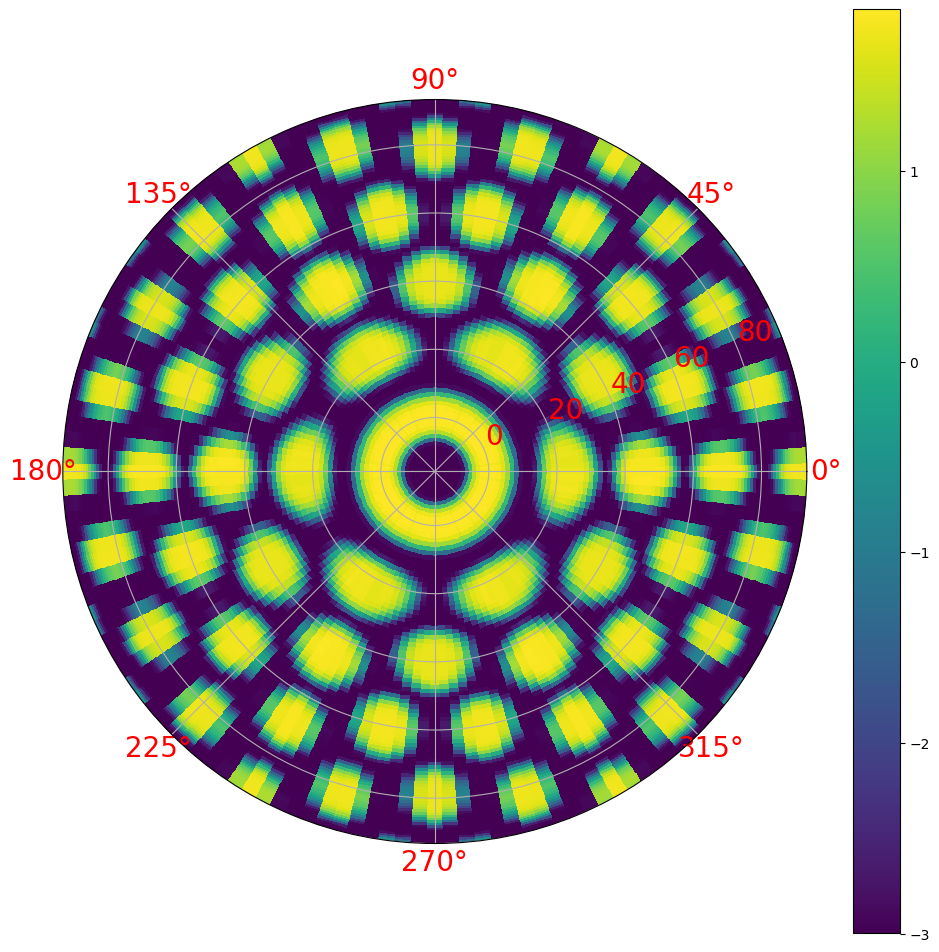

In [7]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111,projection="polar")
Is = np.array(Is).T
#Is_r = np.flip(Is,1)
Iss = np.concatenate((Is,Is,Is,Is,Is,Is),axis=1)
angle_rangess = np.arange(0,360,2.5)/180*np.pi

Isss = np.log10(Iss+0.001) #np.log10(Iss+0.0001)


img = ax.pcolormesh(angle_rangess,-dks*10,Isss)
ax.tick_params(labelsize=20,colors='r')
fig.colorbar(img)